In [144]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [145]:
# Load Data
from google.colab import files
uploaded = files.upload()

Merged_data = pd.read_excel('Merged_data.xlsx')

Saving Merged_data.xlsx to Merged_data (2).xlsx


In [146]:
Merged_data.interpolate(method='linear',inplace=True)
Merged_data.set_index('Date',inplace=True)

In [147]:
Merged_data.index

DatetimeIndex(['2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00',
               '2020-12-31 23:00:00', '2021-01-01 00:00:00',
               ...
               '2023-12-30 00:00:00', '2023-12-30 01:00:00',
               '2023-12-30 02:00:00', '2023-12-30 03:00:00',
               '2023-12-30 04:00:00', '2023-12-30 05:00:00',
               '2023-12-30 06:00:00', '2023-12-30 07:00:00',
               '2023-12-30 08:00:00', '2023-12-30 09:00:00'],
              dtype='datetime64[ns]', name='Date', length=26251, freq=None)

In [148]:
len(Merged_data)

26251

In [149]:
Merged_data.head()

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),wind_gusts_10m (km/h),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),Turbidity
Date,,,,,,,,,,
2020-12-31 15:00:00,4.0,78,0.0,0.05,9.8,20.5,4.4,0.391,55,0.430411
2020-12-31 16:00:00,3.4,85,0.0,0.02,5.6,18.4,4.1,0.391,25,0.522836
2020-12-31 17:00:00,1.5,94,0.0,0.01,7.3,9.7,3.5,0.390,3,0.512069
2020-12-31 18:00:00,0.8,95,0.0,0.00,7.1,9.4,2.9,0.389,0,0.450545
2020-12-31 19:00:00,-0.1,97,0.0,0.00,8.4,10.4,2.3,0.388,0,0.405494


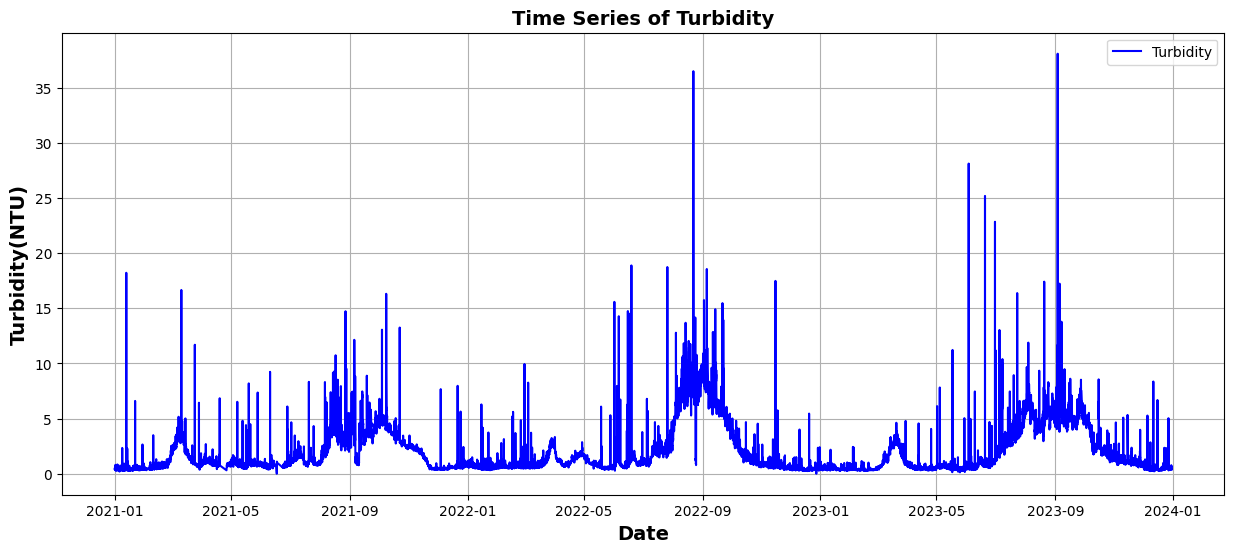

In [150]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(Merged_data.index, Merged_data['Turbidity'], label='Turbidity',color='blue')
plt.title('Time Series of Turbidity',fontsize=14,fontweight='bold')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Turbidity(NTU)',fontsize=14,fontweight='bold')
plt.grid()
plt.legend()
plt.show()

In [171]:
target_col = Merged_data['Turbidity']

In [173]:
target_col

,Turbidity
Date,
2020-12-31 15:00:00,0.430411
2020-12-31 16:00:00,0.522836
2020-12-31 17:00:00,0.512069
2020-12-31 18:00:00,0.450545
2020-12-31 19:00:00,0.405494
...,...
2023-12-30 05:00:00,0.455236
2023-12-30 06:00:00,0.398240
2023-12-30 07:00:00,0.413984


In [198]:
def load_data(file_path):
  df = pd.read_excel(file_path)
  df.set_index('Date',inplace=True)
  return df

In [199]:
def preprocess_data(df, target_col):
    """
    Prepare data for LSTM:
    - Separate features and target
    - Normalize data
    """
    # Handle missing values
    df.interpolate(method='linear',inplace=True)


    # Separate features and target
    features = df.drop(columns=[target_col]).values
    target = df[target_col].values.reshape(-1, 1)

    # Normalize data (0-1 range)
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    features_scaled = feature_scaler.fit_transform(features)
    target_scaled = target_scaler.fit_transform(target)

    # Combine features and target
    data_scaled = np.hstack((features_scaled, target_scaled))

    return data_scaled, feature_scaler, target_scaler



In [200]:
# 3. Create Sequences
def create_sequences(data, n_steps):
    """
    Create input sequences and corresponding outputs
    data: Normalized numpy array with features and target
    n_steps: Number of time steps to look back
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, :])  # All features including target
        y.append(data[i+n_steps, -1])   # Target is always last column
    return np.array(X), np.array(y)


In [201]:
# 4. Train-Test Split
def temporal_train_test_split(X, y, test_size=0.2):
    """Split data sequentially while maintaining temporal order"""
    split_idx = int(len(X) * (1 - test_size))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    return X_train, y_train, X_test, y_test

In [202]:

# 5. Build LSTM Model
def build_lstm_model(input_shape):
    """Create LSTM model architecture"""
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [203]:
# 6. Main Workflow
def main():
    # Configuration
    FILE_PATH = 'your_data.csv'  # Replace with your data file
    TARGET_COL = 'Turbidity'    # Your target column
    N_STEPS = 24                # Look-back window size
    TEST_SIZE = 0.2             # Proportion for test set
    EPOCHS = 20
    BATCH_SIZE = 32

In [205]:
df = load_data('Merged_data.xlsx')

data_scaled, feature_scaler, target_scaler = preprocess_data(df, 'Turbidity')

n_features = data_scaled.shape[1] - 1

In [207]:
# 3. Create sequences
X, y = create_sequences(data_scaled, 24)
print(f"Sequences shape - X: {X.shape}, y: {y.shape}")

Sequences shape - X: (26227, 24, 10), y: (26227,)


In [209]:
# 4. Split data
X_train, y_train, X_test, y_test = temporal_train_test_split(X, y, 0.2)


In [210]:
# 5. Build model
model = build_lstm_model((24, n_features + 1))  # +1 for target column

In [212]:
# 6. Train model
history = model.fit(
      X_train, y_train,
      epochs=5,
      batch_size=32,
      validation_data=(X_test, y_test),
      verbose=1
    )


Epoch 1/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 3.9351e-04 - val_loss: 8.0941e-04
Epoch 2/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 3.6072e-04 - val_loss: 7.5309e-04
Epoch 3/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 4.1844e-04 - val_loss: 7.7177e-04
Epoch 4/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 3.5889e-04 - val_loss: 8.2595e-04
Epoch 5/5
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 3.4002e-04 - val_loss: 7.0087e-04


In [213]:
# 7. Evaluate model
y_pred = model.predict(X_test)

# Inverse transform predictions
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = target_scaler.inverse_transform(y_pred)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2_score = r2_score(y_test_actual, y_pred_actual)
print(f"\nTest MSE: {mse:.4f}, MAE: {mae:.4f}, R2 Score: {r2_score:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Test MSE: 1.0160, MAE: 0.4236, R2 Score: 0.8208


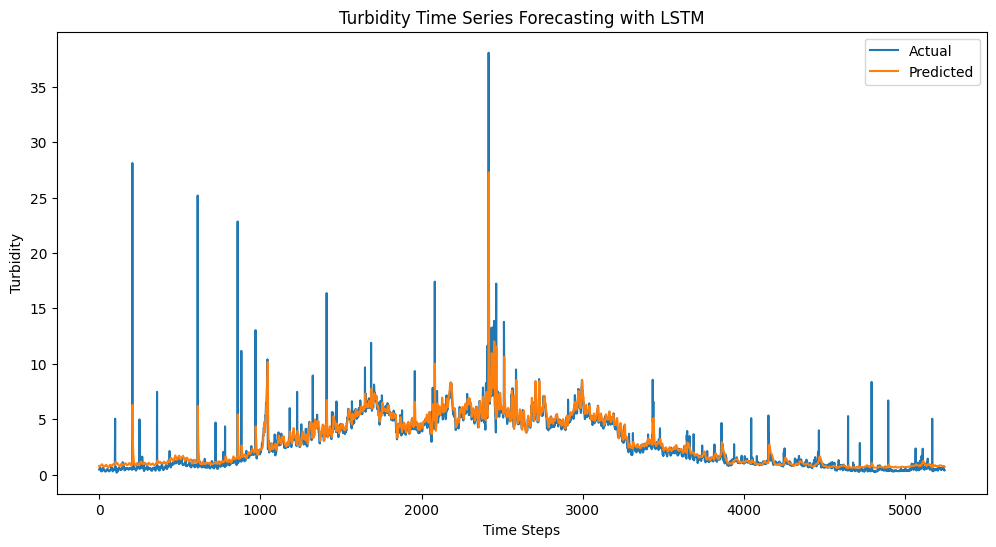

In [215]:
# 8. Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title('Turbidity Time Series Forecasting with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Turbidity')
plt.legend()
plt.show()

